# Demo Time!
## Introducción a Deep Learning con Lasagne: El despertar de la Fuerza 


## Lasagne


In [1]:
from IPython.display import IFrame
IFrame('http://lasagne.readthedocs.io/en/latest/', width=900, height=350)

# Clasifiquemos el tipo de nave que aparece en la imagen!

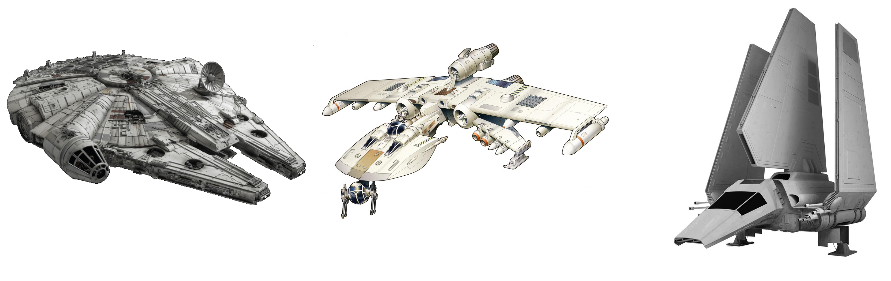

In [2]:
from IPython.display import Image
Image(filename='../images/ships.png') 

# Cómo son nuestros datos de entrada?
![alt text](../images/dataset.png)

## Cargando Imágenes a un Dataframe con Pandas

![alt text](../images/pandas_war.jpg)

In [2]:
import os
import pandas as pd
import cv2

In [3]:
def images_to_file(path_to_photos):
    """ """
    ids = [os.path.splitext(image_id)[0] for image_id in os.listdir(path_to_photos)]
    df_out = pd.DataFrame(columns=['Image', 'Model', 'Model_enc'], index=ids)
    for image_file in os.listdir(path_to_photos):
            image = cv2.imread(os.path.join(path_to_photos, image_file), 0)
            df_out['Image'][os.path.splitext(image_file)[0]] = ' '.join(map(str, image.flatten()))
            df_out['Model'][os.path.splitext(image_file)[0]] = image_file.split('_')[0]
       
    catenc = pd.factorize(df_out['Model'])
    df_out['Model_enc'] = catenc[0]
    print catenc
    df_out.to_csv('./star_wars_data.csv')
    return df_out

### Cómo quedo el archivo que generamos?

In [5]:
!more ./star_wars_data.csv

,Image,Model,Model_enc
falcon_165,135 94 30 14 3 7 2 7 5 7 6 4 6 5 20 58 58 20 20 18 17 26 22 29 20 6 1
1 10 14 47 81 140 144 150 163 146 99 115 117 140 141 153 157 93 102 204 139 115 
140 150 63 14 20 35 38 32 63 49 53 42 65 67 75 107 159 117 37 68 113 43 102 57 3
0 37 52 20 12 22 23 34 24 28 29 66 94 56 38 46 53 39 23 53 58 21 63 119 152 81 7
6 148 161 253 228 172 212 242 228 223 227 213 168 177 164 138 105 125 147 144 14
4 132 140 130 124 130 127 137 174 196 79 41 36 18 11 5 5 4 6 5 5 7 9 5 15 48 60 
22 13 14 18 25 21 25 24 11 11 9 10 36 69 125 143 145 153 150 104 113 113 128 142
 145 165 160 109 161 166 133 126 161 79 10 39 36 43 40 43 47 37 47 56 69 114 136
 157 88 45 89 137 76 87 111 74 61 34 15 14 18 25 16 24 16 23 69 90 56 36 35 45 3
9 32 34 49 26 55 139 100 65 79 67 152 255 221 171 225 224 192 167 166 177 162 16
4 155 121 107 124 157 156 128 128 132 129 132 156 183 202 206 189 28 42 42 17 19
 31 1 16 8 5 5 8 11 5 10 36 60 28 9 11 16 18 20 23 25 16 10 11 9 24 58 110 137 1
36 14

### Ahora a darle formato a nuestros datos para nuestra red ...

In [4]:
import numpy as np
from sklearn.utils import shuffle

In [5]:
def load(images_dir="../data/all/"):
    """Load images and target class for Falcon, Lambda and K-wing ships."""
    df = images_to_file(images_dir)
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    y = df['Model_enc'].values
    X, y = shuffle(X, y, random_state=42)
    y = y.astype(np.int32)
    
    return X, y

### Qué necesitamos para armar nuestras redes ??

In [6]:
import theano
import lasagne
from lasagne.updates import nesterov_momentum, adam
from nolearn.lasagne import NeuralNet
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
                           MaxPool2DLayer, DenseLayer
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import BatchIterator


Using gpu device 0: GeForce GTX 860M (CNMeM is disabled, CuDNN not available)
/usr/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Cómo se define la arquitectura de nuestra red ?!

In [7]:
def create_net(max_epochs=100):
    return NeuralNet(
        layers=[
                (InputLayer, {'shape': (None, 1, 128, 128)}),
                (Conv2DLayer, {'num_filters': 16, 'filter_size': 3, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                # (DropoutLayer, {'p': 0.5}),
                (Conv2DLayer, {'num_filters': 16, 'filter_size': 3, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DenseLayer, {'num_units': 100, 'nonlinearity': lasagne.nonlinearities.rectify}),
                (DropoutLayer, {'p': 0.5}),
                (DenseLayer, {'num_units': 3, 'nonlinearity': lasagne.nonlinearities.softmax}),
        ],
        update=nesterov_momentum,
        update_learning_rate=0.01,
        update_momentum=0.9,
        regression=False,
        objective_loss_function=categorical_crossentropy,
        #batch_iterator_train=BatchIterator(batch_size=512),
        #on_epoch_finished=[
        #    AdjustVariable('update_learning_rate', start=0.03, stop=0.001),
        #    AdjustVariable('update_momentum', start=0.9, stop=0.9999)  # ,
        #],
        max_epochs=max_epochs,
        verbose=1)

In [8]:
from sklearn.cross_validation import train_test_split
x, y = load()
x = x.reshape(-1, 1, 128, 128)
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    random_state=42)
print X_train.shape

(array([0, 1, 1, ..., 0, 0, 1]), Index([u'falcon', u'lambda', u'kwing'], dtype='object'))
(2924, 1, 128, 128)


In [9]:
net = create_net(20)
net.fit(X_train, y_train)

# Neural Network with 1442883 learnable parameters

## Layer information

  #  name        size
---  ----------  ----------
  0  input0      1x128x128
  1  conv2d1     16x126x126
  2  maxpool2d2  16x63x63
  3  conv2d3     16x61x61
  4  maxpool2d4  16x30x30
  5  dense5      100
  6  dropout6    100
  7  dense7      3

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     1.07985     1.03247    1.04589      0.61026  3.24s
      2     0.97411     0.92228    1.05619      0.58291  3.22s
      3     0.84666     0.68007    1.24497      0.79145  3.22s
      4     0.67523     0.56564    1.19374      0.76752  3.22s
      5     0.53231     0.42120    1.26381      0.86325  3.24s
      6     0.41276     0.31291    1.31909      0.89402  3.27s
      7     0.31787     0.25078    1.26752      0.91624  3.23s
      8     0.24842     0.21527    1.15398      0.93162  3.25s
      9     0.17893     0.15879    1.12686      0.952

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f8da69bc0d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f8da69b2f90>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 128, 128)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'W': <lasagne.init.GlorotUniform object at 0x7f8da69bc890>, 'num_filters': 16}), (<class 'lasagne.layers.pool.MaxPool2DLayer'>, {'pool_size': 2}), (<cla....layers.dense.DenseLayer'>, {'num_units': 3, 'nonlinearity': <function softmax at 0x7f8dac0ad320>})],
     loss=None, max_epochs=20, more_params={},
     objective=<function objective at 0x7f8da69bb7d0>,
     objective_loss_function=<function categorical_crossentropy at 0x7f8da77737d0>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f8da69accf8>],
     on_training_finished=[],
     on_

#### Y para chequear nuestros resultados??

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nolearn.lasagne import visualize

In [11]:
print classification_report(y_test, net.predict(X_test))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       330
          1       0.99      0.99      0.99       473
          2       0.98      0.98      0.98       451

avg / total       0.98      0.98      0.98      1254



In [12]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

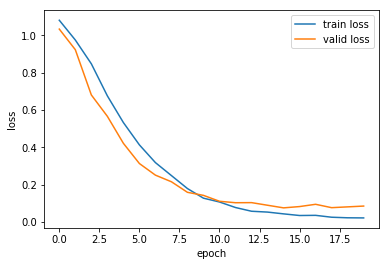

In [13]:
%matplotlib inline
visualize.plot_loss(net)


#### Cómo le fue a nuestra red entrenada en cuanto a clasificación de nuevas naves?
![alt text](../images/confusion_matrix.png)

In [14]:
def plot_matrix(clf, X_test, y_test):
    """Plot Confussion Matrix from a given classifier"""
   
    plt.clf()
    
    cm = confusion_matrix(y_test, clf.predict(X_test))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    print(cm_normalized)
    plt.tick_params(labelsize=20)

    ax = plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Reds)
    cb = plt.colorbar()
    cb.ax.tick_params(axis='both', labelsize=20)
    plt.ylabel("True label", fontsize=20)
    plt.xlabel("Predicted label", fontsize=20)
    plt.xticks(range(3),range(3))
    plt.yticks(range(3),range(3))



Normalized confusion matrix
[[ 0.98787879  0.0030303   0.00909091]
 [ 0.00634249  0.98520085  0.00845666]
 [ 0.00443459  0.01330377  0.98226164]]
[[326   1   3]
 [  3 466   4]
 [  2   6 443]]


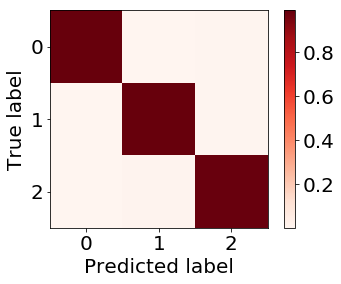

In [15]:
plot_matrix(net, X_test, y_test)
print confusion_matrix(y_test, net.predict(X_test))

### Tengo que entrenar mi red cada vez que quiero usarla?? 
Como guardar y abrir nuestras redes entrenadas

In [16]:
import cPickle as pickle

with open('../data/ship_classifier.pickle', 'wb') as f:
        pickle.dump(net, f, -1)


In [17]:
net_loaded = None
with open('../data/ship_classifier.pickle', 'rb') as f:
       net_loaded = pickle.load(f)

In [18]:
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()

net_loaded.verbose = 1
net_loaded.initialize()
layer_info(net_loaded)

# Neural Network with 1442883 learnable parameters

## Layer information

  #  name        size
---  ----------  ----------
  0  input0      1x128x128
  1  conv2d1     16x126x126
  2  maxpool2d2  16x63x63
  3  conv2d3     16x61x61
  4  maxpool2d4  16x30x30
  5  dense5      100
  6  dropout6    100
  7  dense7      3



### Qué pasa dentro de la red?

In [20]:
net.layers

[(lasagne.layers.input.InputLayer, {'shape': (None, 1, 128, 128)}),
 (lasagne.layers.conv.Conv2DLayer,
  {'W': <lasagne.init.GlorotUniform at 0x7f8da69bc890>,
   'filter_size': 3,
   'num_filters': 16}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.conv.Conv2DLayer,
  {'W': <lasagne.init.GlorotUniform at 0x7f8da69bc850>,
   'filter_size': 3,
   'num_filters': 16}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.dense.DenseLayer,
  {'nonlinearity': <function lasagne.nonlinearities.rectify>,
   'num_units': 100}),
 (lasagne.layers.noise.DropoutLayer, {'p': 0.5}),
 (lasagne.layers.dense.DenseLayer,
  {'nonlinearity': <function lasagne.nonlinearities.softmax>, 'num_units': 3})]

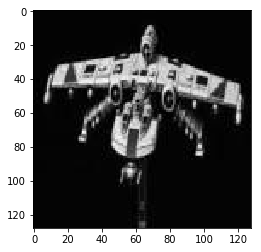

In [19]:
%matplotlib inline

my_image = cv2.imread("../data/kwing.jpg", 0)
plt.imshow(my_image, cmap='gray')
X = np.vstack(my_image) / 255.
plt.imshow(X, cmap='gray')
X = X.astype(np.float32)
X = X.reshape(-1, 1, 128, 128)

In [21]:
net.predict(X)

array([2])

#### Qué tan segura esta mi red de que identifico  ??

In [22]:
proba = net.predict_proba(X)
proba, proba.sum()

(array([[  2.56012962e-03,   9.83874907e-06,   9.97430027e-01]], dtype=float32),
 1.0)

In [23]:
proba[0, np.argmax(proba)]

0.99743003

#### Qué pasa si tapamos partes de nuestra imagen?? Que partes son importantes para la clasificación??

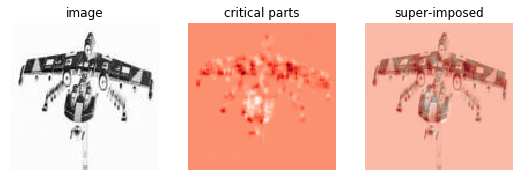

In [24]:
h = visualize.plot_occlusion(net, X, [2], square_length=3)

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

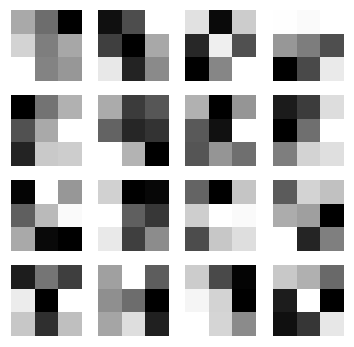

In [25]:
visualize.plot_conv_weights(net.layers_[1])

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

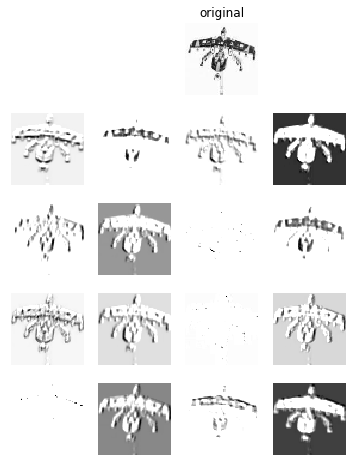

In [26]:
visualize.plot_conv_activity(net.layers_['conv2d3'], X)

### Ahora usemos nuestra red para clasificar desde video!!

In [27]:
tipos_naves = {0: 'Falcon', 1: 'Lambda', 2: 'K-wing'}

def format_net(my_image):
        X = np.vstack(my_image) / 255.
        X = X.astype(np.float32)
        X = X.reshape(-1, 1, 128, 128)
        
        return X

#### Mostrando el resultado frame por frame

In [28]:
import time
import cv2

def classifier_over_video(file_name):
    cap = cv2.VideoCapture(file_name)
    frames_count = cap.get(7)
    
    for frame_id in range(int(frames_count)):
        ret, frame = cap.read()
        frame_ = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame_ = cv2.equalizeHist(frame_)
        res = cv2.resize(frame_, (128, 128), interpolation = cv2.INTER_CUBIC)
        X = format_net(res)
        
        pred = tipos_naves[net.predict(X)[0]]
        proba = net.predict_proba(X)
        proba = str(proba[0, np.argmax(proba)])
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, pred, (10, 500), font, 4, (255,255,255), 2, cv2.LINE_AA)
        cv2.putText(frame, proba, (10, 800), font, 4, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.imshow('frame',frame)
        cv2.waitKey(1)
        
    cap.release()
    cv2.destroyAllWindows()

In [29]:
classifier_over_video("../data/videos_demo/k-wing_nerdearla.mp4")

#### Con una pequeña trampa podemos tener una idea mas estable sobre el video ...

In [30]:
import time
import cv2
from collections import Counter

def classifier_over_video_most_common(file_name):
    cap = cv2.VideoCapture(file_name)
    frames_count = cap.get(7)
    clase = []
    
    for frame_id in range(int(frames_count)):
        ret, frame = cap.read()
        frame_ = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame_ = cv2.equalizeHist(frame_)
        res = cv2.resize(frame_, (128, 128), interpolation = cv2.INTER_CUBIC)
        X = format_net(res)
        clase.append(net.predict(X)[0])
        font = cv2.FONT_HERSHEY_SIMPLEX
        mi_nave_frecuente = Counter(clase).most_common(1)[0][0]
        cv2.putText(frame, tipos_naves[mi_nave_frecuente], (10,500), font, 4,(255,255,255), 2, cv2.LINE_AA)
        cv2.imshow('frame', frame)
        cv2.waitKey(1)
        
    cap.release()
    cv2.destroyAllWindows()

In [33]:
classifier_over_video_most_common("../data/videos_demo/otro_k-wing_nerdearla.mp4")

### Quiero profundizar más!

- [Neural Networks and Deep Learning free online book](http://neuralnetworksanddeeplearning.com/index.html)
- [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/)
- [Unsupervised Feature Learning and Deep Learning.](http://deeplearning.stanford.edu/tutorial/)
